In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop , Adam
import os
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping

<Strong> Grabbing the data from stored files (originally pulled from Binance) </Strong>

In [24]:
df_eth = pd.read_csv("ETH_1h_data.csv")

In [25]:
df_eth

,date,open,high,low,close,volume
0,2017-08-17 04:00:00.000,301.13,302.57,298.00,301.61,125.66877
1,2017-08-17 05:00:00.000,301.61,303.28,300.00,303.10,377.67246
2,2017-08-17 06:00:00.000,302.40,304.44,301.90,302.68,303.86672
3,2017-08-17 07:00:00.000,302.68,307.96,302.60,307.96,754.74510
4,2017-08-17 08:00:00.000,307.95,309.97,307.00,308.62,150.75029
...,...,...,...,...,...,...
39216,2022-02-11 10:00:00,3102.22,3115.98,3075.24,3106.33,12865.43100
39217,2022-02-11 11:00:00,3106.34,3109.86,3083.93,3088.30,7796.24450
39218,2022-02-11 12:00:00,3088.30,3122.00,3079.16,3102.23,13475.38960
39219,2022-02-11 13:00:00,3102.22,3127.00,3095.00,3121.64,13585.96880


In [26]:
df_headers = df_eth.columns

<Strong> Grabbing the closing price (univariate) </Strong>

In [27]:
# Removing everything but the closing price
eth_data = df_eth.values[:, 4 ,].astype(float)

len(eth_data)

39221

<Strong> Scaling the data  </Strong>

In [28]:
percTrain = 70
percVal = 20

onePercent = len(eth_data) // 100
numberTraining = onePercent * percTrain

scaler = MinMaxScaler()
reshaped_data = eth_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_eth = scaler.transform(reshaped_data)

<Strong> Creating Matrix in Sliding window form <Strong>

In [29]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

In [30]:
window_length = 24
features = 1


sliding_winda_eth = sliding_window(scaled_eth , window_length)

<Strong> Splitting the data after we create Sliding Window matrix (more data) </Strong>

In [31]:
# Splitting the data after creating the sliding window data

def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

In [32]:
#Reshaping the data so we can use min-max a
eth_train , eth_val , eth_test = splitting_train_test(sliding_winda_eth)

print(eth_train[0].shape)

(27370, 24, 1)


<Strong> Creating the model </Strong>

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 24, 30)       3840        ['input_2[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 24, 30)       0           ['lstm_2[0][0]']                 
                                                                                                  
 gru_1 (GRU)                    (None, 30)           2970        ['input_2[0][0]']                
                                                                                            

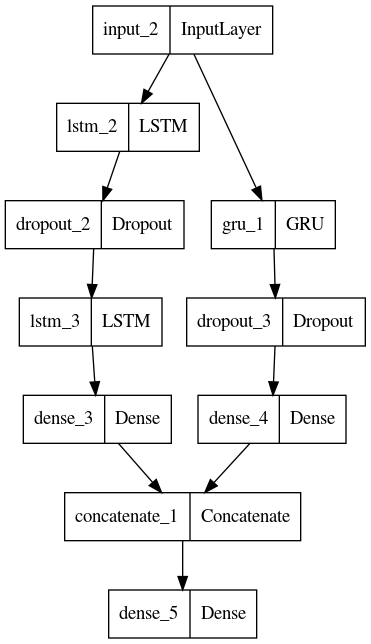

In [33]:
inputs = Input(shape = (window_length , features) )

#activation=layers.LeakyReLU(alpha=0.01)
#From deep learning in python -- better to use recurrent dropout so error propergates correctly
x = LSTM(30 , return_sequences = True )(inputs)
x = Dropout(0.03)(x) 
x = LSTM(50)(x)
x = Dense(128 , activation=layers.LeakyReLU(alpha=0.01))(x)

y = GRU(30,input_shape=(window_length , features))(inputs)
y = Dropout(0.03)(y)
y = Dense(128 , activation=layers.LeakyReLU(alpha=0.01))(y)

final = Concatenate()([x,y])
final = Dense(1)(final)

model = tf.keras.Model(inputs=inputs, outputs= final)

model.summary()
plot_model(model)

<Strong> Compiling the model </Strong>

In [34]:
opt = Adam(0.008)
model.compile(optimizer=opt , loss = 'mse')

<Strong> Creating a callback to avail of early stopping </Strong>

In [35]:
earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)

<Strong> Training the model and storing the epoch where training stopped </Strong>

In [36]:
#Validation set needs to be in a tuple with x , y
history = model.fit(eth_train[0] , eth_train[1] , validation_data = eth_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks = [earlyStopping] )
num_epochs = earlyStopping.stopped_epoch


Epoch 1/300


2022-03-15 13:32:25.299092: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


54/54 [==============================] - 6s 26ms/step - loss: 0.0039 - val_loss: 0.0131
Epoch 2/300
54/54 [==============================] - 0s 8ms/step - loss: 9.2869e-05 - val_loss: 0.0101
Epoch 3/300
54/54 [==============================] - 0s 8ms/step - loss: 7.3262e-05 - val_loss: 0.0097
Epoch 4/300
54/54 [==============================] - 0s 9ms/step - loss: 6.2873e-05 - val_loss: 0.0086
Epoch 5/300
54/54 [==============================] - 0s 8ms/step - loss: 5.4461e-05 - val_loss: 0.0096
Epoch 6/300
54/54 [==============================] - 0s 8ms/step - loss: 5.1304e-05 - val_loss: 0.0109
Epoch 7/300
54/54 [==============================] - 0s 8ms/step - loss: 4.9262e-05 - val_loss: 0.0107
Epoch 8/300
54/54 [==============================] - 0s 8ms/step - loss: 4.8908e-05 - val_loss: 0.0098
Epoch 9/300
54/54 [==============================] - 0s 8ms/step - loss: 4.5310e-05 - val_loss: 0.0078
Epoch 10/300
54/54 [==============================] - 0s 9ms/step - loss: 4.2689e-05 - v

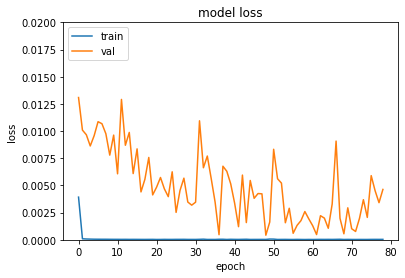

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0,0.02])
plt.show()

<Strong> Testing on the validation data once again , hyper-parameter adjustment. <Strong>

In [38]:
validation_predict = model.predict(eth_val[0])
validation_actual = eth_val[1]

mean_squared_error(validation_actual , validation_predict)

91.7964465009049

<Strong> Combining the train and validation set when perfected hyper-parameters and training on fresh model. </Strong>

In [39]:
train_and_val = np.concatenate([eth_train[0] , eth_val[0]] )
train_and_val_targets = np.concatenate([eth_train[1] , eth_val[1] ])

freshModel = tf.keras.Model(inputs=inputs, outputs= final)
freshModel.compile(optimizer=opt , loss = 'mse')

final = freshModel.fit(train_and_val , train_and_val_targets , batch_size = 512  , epochs = num_epochs , verbose = 1 )

Epoch 1/78
69/69 [==============================] - 3s 8ms/step - loss: 0.1145
Epoch 2/78
69/69 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 3/78
69/69 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 4/78
69/69 [==============================] - 1s 7ms/step - loss: 9.7242e-04
Epoch 5/78
69/69 [==============================] - 1s 7ms/step - loss: 8.4691e-04
Epoch 6/78
69/69 [==============================] - 0s 7ms/step - loss: 6.7303e-04
Epoch 7/78
69/69 [==============================] - 0s 7ms/step - loss: 6.1607e-04
Epoch 8/78
69/69 [==============================] - 0s 7ms/step - loss: 6.1910e-04
Epoch 9/78
69/69 [==============================] - 0s 7ms/step - loss: 5.2639e-04
Epoch 10/78
69/69 [==============================] - 0s 7ms/step - loss: 4.9647e-04
Epoch 11/78
69/69 [==============================] - 0s 7ms/step - loss: 4.3388e-04
Epoch 12/78
69/69 [==============================] - 1s 7ms/step - loss: 4.8031e-04
Epoch 13/78
6

<Strong> Finally testing on test set and grabbing evaluation metrics </Strong>

In [40]:
test_predict = freshModel.predict(eth_test[0])

test_actual = eth_test[1]

In [43]:
print(mean_absolute_error(test_actual , test_predict))
print(mean_absolute_percentage_error(test_actual , test_predict))
print(mean_squared_error(test_actual , test_predict , squared = False))
print(mean_squared_error(test_actual , test_predict))

60.38176739046513
0.015617313377087378
74.05307496842312
5483.857912278894


<Strong> For Predicting more than 1 day in the future - Test Set. </Strong>

In [44]:
def steps_in_future(hours_in_future , data):
    
    #All the hours_in_future time predictions
    predictions = []
    
    # Have to cut off the (hours_in_future - 1) off the test set to avoid out of bounds error
    test_data = data[0][:-(hours_in_future - 1)]
    
    for x in range (len(test_data)):
        #Going through all the windows
        last_window = test_data[x].reshape(1,-1)
    
            # Make as many predictions as hours_in_future
        for i in range(hours_in_future):
            
            # Take the predicted value from the last window in training set
            last_prediction = model.predict(last_window)[0]

            #shifting the window size one step down
            last_window[0] = np.roll(last_window[0], -1)

            #replacing the old value with new prediction
            last_window[0 , (len(last_window[0]) - 1)] = last_prediction

        #append prediction
        predictions.append(last_prediction)
    
    return predictions

In [45]:
three_day_predictions = steps_in_future(3, eth_test)
five_day_predictions = steps_in_future(5, eth_test)
seven_day_predictions = steps_in_future( 7, eth_test)
nine_day_predictions = steps_in_future( 9, eth_test)
eleven_day_predictions = steps_in_future( 11, eth_test)

In [47]:
# Targets to compare  

targets_in_future_three = eth_test[1][(3 - 1):]
targets_in_future_five = eth_test[1][(5 - 1):]
targets_in_future_seven = eth_test[1][(7 - 1):]
targets_in_future_nine = eth_test[1][(9 - 1):]
targets_in_future_eleven = eth_test[1][(11 - 1):]

In [48]:
def get_eval_metrics(num_days , actual , results):
    
    mae = mean_absolute_error(actual , results)
    mse = mean_squared_error(actual , results )
    rmse = mean_squared_error(actual , results , squared = False)
    mape = mean_absolute_percentage_error(actual , results)

    print(num_days , "MAE :" , mae ,"MSE :" , mse , "RMSE :" , rmse , "MAPE :" , mape)

    return mae , mse , rmse , mape

In [49]:
three_days_mae , three_days_mse , three_days_rmse , three_days_mape = get_eval_metrics("Three Hour Forecast" , targets_in_future_three , three_day_predictions)
five_days_mae , five_days_mse , five_days_rmse , five_days_mape = get_eval_metrics("Five Hour Forecast" , targets_in_future_five , five_day_predictions)
seven_days_mae , seven_days_mse , seven_days_rmse , seven_days_mape = get_eval_metrics("Seven Hour Forecast" , targets_in_future_seven , seven_day_predictions)
nine_days_mae , nine_days_mse , nine_days_rmse , nine_days_mape = get_eval_metrics("Nine Hour Forecast" , targets_in_future_nine , nine_day_predictions)
eleven_days_mae , eleven_days_mse , eleven_days_rmse , eleven_days_mape = get_eval_metrics("Eleven Hour Forecast" , targets_in_future_eleven ,eleven_day_predictions)

Three Hour Forecast MAE : 144.97334177979616 MSE : 29040.97660236416 RMSE : 170.41413263683316 MAPE : 0.037463009531038365
Five Hour Forecast MAE : 278.1820860984048 MSE : 93385.69353563107 RMSE : 305.5907288116429 MAPE : 0.07284139264792892
Seven Hour Forecast MAE : 453.4969083002469 MSE : 231078.09476753845 RMSE : 480.7058297623802 MAPE : 0.11999954071479813
Nine Hour Forecast MAE : 664.0195756226311 MSE : 482699.55979735125 RMSE : 694.7658309080487 MAPE : 0.1763877282699429
Eleven Hour Forecast MAE : 895.3884372576878 MSE : 872186.0253482417 RMSE : 933.9090027129205 MAPE : 0.23788623808046666
